In [1]:
from os.path import dirname, join as pjoin
import scipy.io as sio

In [2]:
mat_fname = 'ECoG_Handpose.mat'

In [3]:
mat_contents = sio.loadmat(mat_fname)['y']

In [4]:
mat_contents

array([[ 0.00000000e+00,  8.33333333e-04,  1.66666667e-03, ...,
         4.22518333e+02,  4.22519167e+02,  4.22520000e+02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -1.06701961e+05, -1.06699477e+05, -1.06697859e+05],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -8.62051094e+04, -8.62023672e+04, -8.61986562e+04],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.53902262e-01,  1.53902262e-01,  1.53902262e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.61574081e-01,  1.61574081e-01,  1.61574081e-01],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         2.34732822e-01,  2.34732822e-01,  2.34732822e-01]])

In [5]:
mat_data = mat_contents

In [6]:
mat_data.shape
# 67 channels
# channel 1 - sample time
# channel 2-61 - ECoG
# channel 62 - paradigm info
#              0 - relax
#              1 - fist movement
#              2 - peace movement
#              3 - open hand
# channel 63-67 - glove info
#              63 - thumb
#              64 - index
#              65 - middle
#              66 - ring
#              67 - little

(67, 507025)

In [7]:
import mne
import numpy as np
from scipy import signal

import matplotlib.pyplot as plt
from mne.time_frequency import fit_iir_model_raw
from mne.filter import create_filter

In [8]:
# extract ecog channels into nparray
ecog_data = mat_data[1:61]

In [9]:
paradigm_info = mat_data[61]

In [10]:
# count unique movements (labels?)
np.unique(paradigm_info, return_counts=True)

(array([0., 1., 2., 3.]), array([286801,  73440,  73440,  73344]))

In [11]:
mat_data[0]

array([0.00000000e+00, 8.33333333e-04, 1.66666667e-03, ...,
       4.22518333e+02, 4.22519167e+02, 4.22520000e+02])

# CREATE MNE OBJECT

In [12]:
sampling_freq = 1200
ch_names = ["sample_time"] + [f'CH_{i}' for i in range(1, 61)] + ["paradigm_info"]
ch_types = ['misc'] + ['ecog'] * 60 + ['stim']

In [13]:
len(ch_names), len(ch_types)

(62, 62)

In [14]:
info = mne.create_info(ch_names=ch_names, sfreq=1200, ch_types=ch_types)

In [15]:
raw = mne.io.RawArray(mat_data[0:62, :], info)

Creating RawArray with float64 data, n_channels=62, n_times=507025
    Range : 0 ... 507024 =      0.000 ...   422.520 secs
Ready.


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


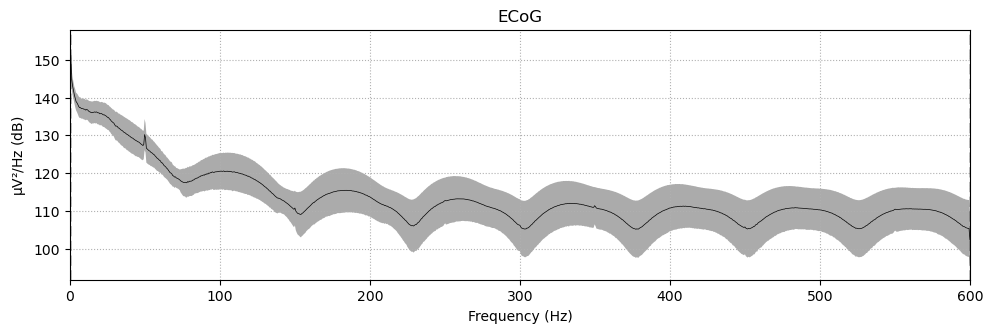

In [16]:
# plot ECoG channels only
raw.plot_psd(average=True)
plt.show();

In [17]:
# # plot all channels individually over time using matplotlib

# fig, axes = plt.subplots(60, 1, figsize=(10, 60))
# for i, ax in enumerate(axes):
#     ax.plot(ecog_data[i])
#     ax.set_title(raw.ch_names[i])

# fig.tight_layout()
# plt.show()
# plt.close()

In [18]:
# show info on the raw object
raw.info

<Info | 7 non-empty values
 bads: []
 ch_names: sample_time, CH_1, CH_2, CH_3, CH_4, CH_5, CH_6, CH_7, CH_8, ...
 chs: 1 misc, 60 ECoG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 600.0 Hz
 meas_date: unspecified
 nchan: 62
 projs: []
 sfreq: 1200.0 Hz
>

In [19]:
sample_time = mat_data[0, :]

In [20]:
time_diff = np.diff(sample_time)

In [21]:
paradigm_info = mat_data[61, :]
finger_movement_onsets = mat_data[62:, :]

In [22]:
# re-reference to average
raw.set_eeg_reference('average')

ECoG channel type selected for re-referencing
Applying average reference.
Applying a custom ('ECoG',) reference.


<RawArray | 62 x 507025 (422.5 s), ~239.9 MB, data loaded>

In [23]:
raw = raw.filter(100, 300)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1e+02 - 3e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 100.00
- Lower transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 87.50 Hz)
- Upper passband edge: 300.00 Hz
- Upper transition bandwidth: 75.00 Hz (-6 dB cutoff frequency: 337.50 Hz)
- Filter length: 159 samples (0.133 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    1.2s finished


In [24]:
# recursive 5th order notch filter
raw.notch_filter(50, filter_length='auto', phase='zero')

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 7921 samples (6.601 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.9s finished


<RawArray | 62 x 507025 (422.5 s), ~239.9 MB, data loaded>

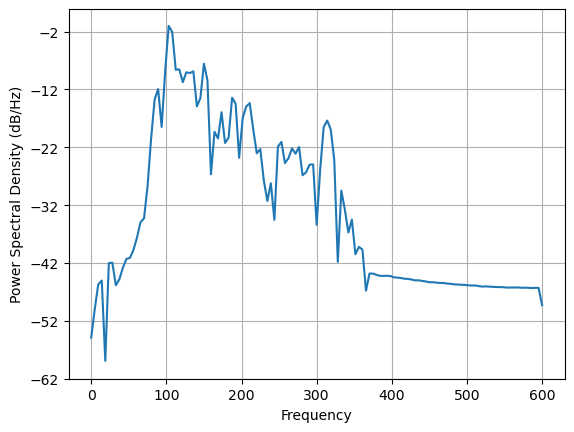

In [25]:
plt.figure()
plt.psd(raw.get_data()[25, 10000:10200], Fs=raw.info['sfreq'])
plt.show()

In [26]:
order = 12  # define model order

# Estimate AR models on raw data
b, a = fit_iir_model_raw(raw, order=order, picks=['ecog'], tmin=sample_time[0], tmax=sample_time[-1])
d, times = raw[25, 10000:10200]  # look at 25th channel for 200 samples
d = d.ravel()  # make flat vector
innovation = signal.convolve(d, a, 'valid')
d_ = signal.lfilter(b, a, innovation)  # regenerate the signal
d_ = np.r_[d_[0] * np.ones(order), d_]  # dummy samples to keep signal length

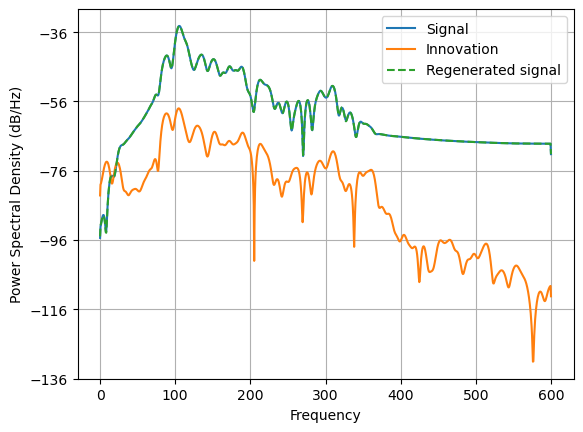

In [27]:
plt.figure()
plt.psd(d, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(innovation, Fs=raw.info['sfreq'], NFFT=2048)
plt.psd(d_, Fs=raw.info['sfreq'], NFFT=2048, linestyle='--')
plt.legend(('Signal', 'Innovation', 'Regenerated signal'))
plt.show()

In [28]:
m = raw._data
m.mean(), m.std(), m.shape

(3.421427444406093, 67.12192482133842, (62, 507025))

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.707 (s)


/home/saras/miniconda3/envs/bci/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


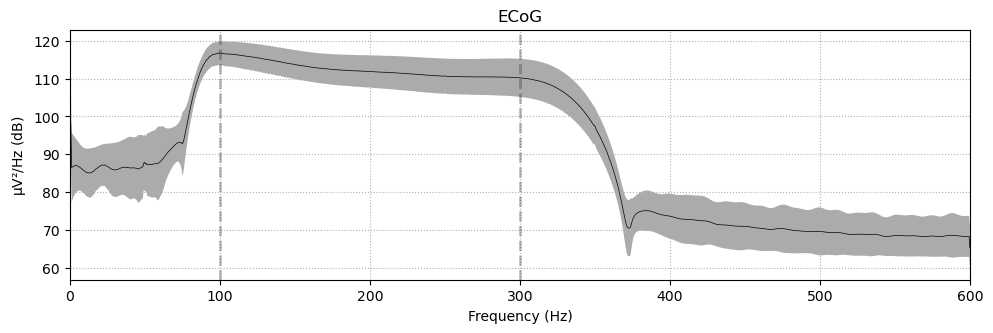

In [29]:
raw.plot_psd(average=True)
plt.show()

In [30]:
event_labels = dict(fist_movement = 1, peace_movement = 2, open_hand = 3)
# find events in the MNE raw object
events = mne.find_events(raw, stim_channel="paradigm_info", shortest_event=1, verbose=True)

90 events found
Event IDs: [1 2 3]


In [31]:
epochs = mne.Epochs(raw, events, tmin=0., tmax=1.5, baseline=(0, 0))
print(epochs)

Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
<Epochs |  90 events (good & bad), 0 - 1.5 sec, baseline 0 – 0 sec, ~63 kB, data not loaded,
 '1': 30
 '2': 30
 '3': 30>


In [32]:
import scipy.io as sio
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import LabelEncoder
import mne.decoding
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import Vectorizer, Scaler, cross_val_multiscore

In [33]:
X = epochs.get_data() # n_epochs, n_channels, n_times
y = epochs.events[:, -1]

X.shape, y.shape

Using data from preloaded Raw for 90 events and 1801 original time points ...
0 bad epochs dropped


((90, 62, 1801), (90,))

In [34]:
X.shape[0] != y.shape[0]

False

SkLearn models

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from mne import Epochs, pick_types, events_from_annotations
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.metrics import f1_score
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [36]:
X = epochs.get_data() # n_epochs, n_channels, n_times
y = epochs.events[:, 2]

X.shape, y.shape

Using data from preloaded Raw for 90 events and 1801 original time points ...


((90, 62, 1801), (90,))

In [37]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((72, 62, 1801), (18, 62, 1801), (72,), (18,))

In [38]:
# pyriemann feature extraction and LDA

print("Pyremann features + LDA")

# define the pipeline
pipe = Pipeline([('cov', Covariances(estimator='lwf')), ('ts', TangentSpace()), ('lda', LinearDiscriminantAnalysis())])

# cross validation
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=1)
print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))

# fit the pipeline
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# calculate the accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score: {:.2f}".format(f1))

Pyremann features + LDA
Classification accuracy: 0.59 +/-0.08
Accuracy: 83.33%
F1 score: 0.83


In [39]:
# CSP feature extraction and LDA

print("CSP features + LDA")

# define the pipeline
pipe = Pipeline([('csp', CSP(n_components=4, log=False, norm_trace=False)), ('lda', LinearDiscriminantAnalysis())])

# cross validation
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=1)
# remove NaN values from scores
scores = scores[~np.isnan(scores)]

print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))

# fit the pipeline
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# calculate the accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

print("F1 score: {:.2f}".format(f1))

CSP features + LDA
Computing rank from data with rank=None
    Using tolerance 6.7e+02 (2.2e-16 eps * 62 dim * 4.9e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e+02 (2.2e-16 eps * 62 dim * 4.7e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e+02 (2.2e-16 eps * 62 dim * 4.3e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e+02 (2.2e-16 eps * 62 dim * 4.7e+16  m

In [40]:
print("CSP features + LDA")
print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))
print(f"Accuracy: {accuracy * 100:.2f}%")
print("F1 score: {:.2f}".format(f1))

CSP features + LDA
Classification accuracy: 0.71 +/-0.09
Accuracy: 66.67%
F1 score: 0.66


In [41]:
# pyremann feature extraction and random forest classifier

print("Pyremann features + Random Forest")

# define the pipeline
pipe = Pipeline([('cov', Covariances(estimator='lwf')), ('ts', TangentSpace()), ('rf', RandomForestClassifier(n_estimators=100))])

# cross validation
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=1)
print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))

# fit the pipeline
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# calculate the accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score: {:.2f}".format(f1))

Pyremann features + Random Forest
Classification accuracy: 0.75 +/-0.12
Accuracy: 100.00%
F1 score: 1.00


In [42]:
# CSP feature extraction and random forest classifier

print("CSP features + Random Forest")

# define the pipeline
pipe = Pipeline([('csp', CSP(n_components=60, log=False, norm_trace=False)), ('rf', RandomForestClassifier(n_estimators=100))])

# cross validation
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=1)
# remove NaN values from scores
scores = scores[~np.isnan(scores)]

print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))

# fit the pipeline
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# calculate the accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score: {:.2f}".format(f1))

CSP features + Random Forest
Computing rank from data with rank=None
    Using tolerance 6.7e+02 (2.2e-16 eps * 62 dim * 4.9e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e+02 (2.2e-16 eps * 62 dim * 4.7e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e+02 (2.2e-16 eps * 62 dim * 4.3e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e+02 (2.2e-16 eps * 62 dim * 

In [43]:
print("CSP features + Random Forest")
print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))
print(f"Accuracy: {accuracy * 100:.2f}%")
print("F1 score: {:.2f}".format(f1))

CSP features + Random Forest
Classification accuracy: 0.72 +/-0.13
Accuracy: 88.89%
F1 score: 0.89


In [44]:
# pyriemann feature extraction and SVM classifier

print("Pyriemann features + SVM")

# define the pipeline
pipe = Pipeline([('cov', Covariances(estimator='lwf')), ('ts', TangentSpace()), ('svm', SVC(kernel='linear'))])

# cross validation
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=1)
print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))

# fit the pipeline
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# calculate the accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score: {:.2f}".format(f1))

Pyriemann features + SVM
Classification accuracy: 0.94 +/-0.07
Accuracy: 100.00%
F1 score: 1.00


In [45]:
# CSP feature extraction and SVM classifier

print("CSP features + SVM")

# define the pipeline
pipe = Pipeline([('csp', CSP(n_components=60, log=False, norm_trace=False)), ('svm', SVC(kernel='linear'))])

# cross validation
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
scores = cross_val_score(pipe, X_train, y_train, cv=cv, n_jobs=1)

# remove NaN values from scores
scores = scores[~np.isnan(scores)]

print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))

# fit the pipeline
pipe.fit(X_train, y_train)

# predict
y_pred = pipe.predict(X_test)

# calculate the accuracy
accuracy = np.sum(y_pred == y_test) / len(y_test)
print(f"Accuracy: {accuracy * 100:.2f}%")

# calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print("F1 score: {:.2f}".format(f1))

CSP features + SVM
Computing rank from data with rank=None
    Using tolerance 6.7e+02 (2.2e-16 eps * 62 dim * 4.9e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.5e+02 (2.2e-16 eps * 62 dim * 4.7e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 5.9e+02 (2.2e-16 eps * 62 dim * 4.3e+16  max singular value)
    Estimated rank (mag): 62
    MAG: rank 62 computed from 62 data channels with 0 projectors
Reducing data rank from 62 -> 62
Estimating covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6.4e+02 (2.2e-16 eps * 62 dim * 4.7e+16  m

In [46]:
print("CSP + SVM")
print("Classification accuracy: %0.2f +/-%0.2f" % (scores.mean(), scores.std()))
print(f"Accuracy: {accuracy * 100:.2f}%")
print("F1 score: {:.2f}".format(f1))

CSP + SVM
Classification accuracy: 0.37 +/-0.08
Accuracy: 38.89%
F1 score: 0.36
